In [1]:
# Getting the data generators for the training and validation sets
import os
import sys

module_path = os.path.abspath('../utils')
print("Adding to sys.path:", module_path)
sys.path.append(module_path)

from data_prep import get_data_generators
train_gen, valid_gen, full_gen, _ = get_data_generators('../data/pokemon.csv', '../data/pokemon-img/pokemon/pokemon/')

Adding to sys.path: c:\Users\halod\Documents\Projects\poke_classy\utils

{'bug': 0, 'dark': 1, 'dragon': 2, 'electric': 3, 'fairy': 4, 'fighting': 5, 'fire': 6, 'flying': 7, 'ghost': 8, 'grass': 9, 'ground': 10, 'ice': 11, 'normal': 12, 'poison': 13, 'psychic': 14, 'rock': 15, 'steel': 16, 'water': 17}
Found 576 validated image filenames.
Found 145 validated image filenames.
Found 721 validated image filenames.


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# show what 1 image from the batch looks like
train_img, train_lab = next(train_gen)
print(train_img.shape, train_lab.shape)

plt.imshow(train_img[5])
plt.show()

In [2]:
from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

In [ ]:
# defining the model based on the base model
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# freeze the base
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(18, activation='sigmoid')  # 18 is the number of pokemon types so 18 classes
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # For multi-label
    metrics=['accuracy']
)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 18)                

In [ ]:
# training top layers first
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# defining callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=3,         # Stop after 3 epochs of no improvement
        restore_best_weights=True
    ),
    ModelCheckpoint(
        filepath='best_initial_weights.h5',
        save_best_only=True,
        monitor='val_loss',
        mode='min',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,         # Wait 2 epochs before reducing LR
        min_lr=1e-6,
        verbose=1
    )
]


history = model.fit(
    train_gen,
    epochs=5,
    validation_data=valid_gen,
    callbacks=callbacks
)

In [ ]:
#fine tune
base_model.trainable = True


model.compile(
    optimizer=Adam(1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=10,
    callbacks=callbacks,
    initial_epoch=history.epoch[-1]
)


Epoch 5/10
18/18 [==============================] - ETA: 0s - loss: 1.0547 - accuracy: 0.0538
Epoch 5: val_loss did not improve from 0.27560
18/18 [==============================] - 37s 1s/step - loss: 1.0547 - accuracy: 0.0538 - val_loss: 0.2867 - val_accuracy: 0.0414 - lr: 1.0000e-05
Epoch 6/10
18/18 [==============================] - ETA: 0s - loss: 0.9723 - accuracy: 0.0556
Epoch 6: val_loss did not improve from 0.27560
18/18 [==============================] - 20s 1s/step - loss: 0.9723 - accuracy: 0.0556 - val_loss: 0.3025 - val_accuracy: 0.0414 - lr: 1.0000e-05
Epoch 7/10
18/18 [==============================] - ETA: 0s - loss: 0.8992 - accuracy: 0.0486
Epoch 7: val_loss did not improve from 0.27560

Epoch 7: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
18/18 [==============================] - 20s 1s/step - loss: 0.8992 - accuracy: 0.0486 - val_loss: 0.3117 - val_accuracy: 0.0414 - lr: 1.0000e-05
Epoch 8/10
18/18 [==============================] - ETA: 0s - 

In [26]:
loss, acc = model.evaluate(full_gen)
print(f"Validation Accuracy: {acc:.2f}")

23/23 [==============================] - 5s 223ms/step - loss: 0.2903 - accuracy: 0.0763
Validation Accuracy: 0.08


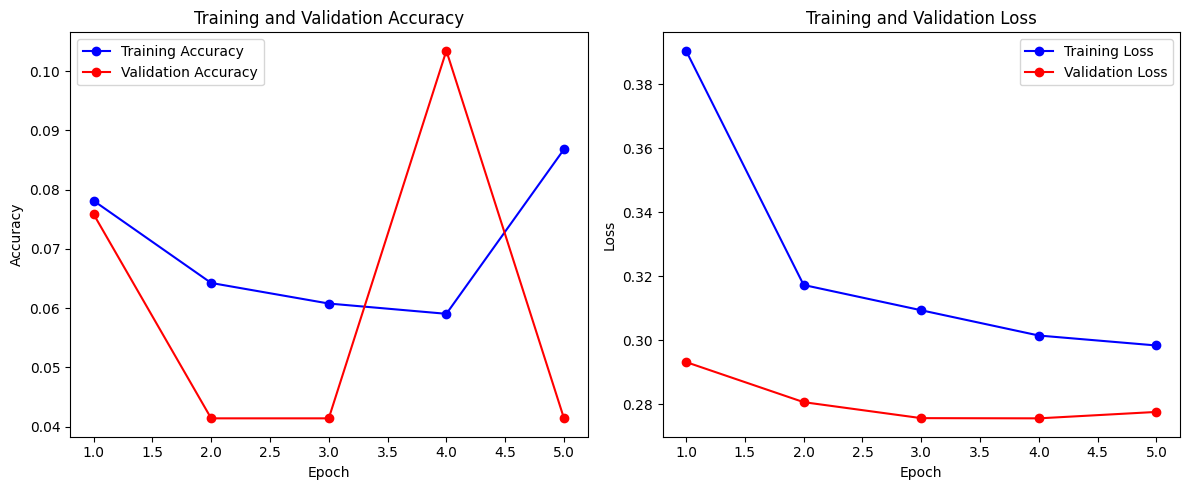

In [21]:
import matplotlib.pyplot as plt

# Extract values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
